In [1]:
import pandas as pd
import yfinance as yf 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
# import os 

# Setup:

In [2]:
# Manual inputs
TIMEFRAME = '1d'
LOOKBACK_PERIOD = '2y'

crnt_portfolio = [
'AMZN',
'CBOE',
'ECL',
'GE',
'GOOGL',
'KO',
'LDOS',
'MET',
'META',
'MMC',
'MTB',
'PHM',
'QQQ',
'SPY',
'TRGP',
'TXN',
'USB',
'VRTX',
'WDC',
'WFC',
'XOM'
]

In [20]:
print(str(crnt_portfolio))

['AMZN', 'CBOE', 'ECL', 'GE', 'GOOGL', 'KO', 'LDOS', 'MET', 'META', 'MMC', 'MTB', 'PHM', 'QQQ', 'SPY', 'TRGP', 'TXN', 'USB', 'VRTX', 'WDC', 'WFC', 'XOM']


# Preprocessing:

In [3]:
# Get the list of S&P500 stocks from Wikipedia
URL = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(URL)
tickers = sp500[0]['Symbol'].to_list()
print(tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', '

In [4]:
tickers = ['SPY'] + tickers # Add SPY to the list of tickers, will be used as a benchmark

In [6]:
_uptrend_stocks = [] 
cached_returns = {}
sma200, sma50 = {}, {}

for stock in tickers:
  data = yf.Ticker(stock).history(period=LOOKBACK_PERIOD, interval=TIMEFRAME) 
  cached_returns[stock] = data
  data["returns"] =  np.log(1+data["Close"].pct_change())
  data.rename(columns={"returns": stock}, inplace=True)

  # Calculate the 200 and 50 day moving averages
  data['200d'] = data['Close'].rolling(window=200).mean()
  sma200[stock] = data['200d']
  data['50d'] = data['Close'].rolling(window=50).mean()
  sma50[stock] = data['50d']

  # Filter #1 : sma50 > sma200
  if len(data) > 0 and sma50[stock][-1] > sma200[stock][-1]:
    _uptrend_stocks.append(data[stock])

ERROR BRK.B: No data found, symbol may be delisted
ERROR BF.B: No price data found, symbol may be delisted (period=2y)


In [7]:
# drift = mean - 0.5 * variance (for sorting)
er_stocks = {}

universe_stocks = [] # Final filtered list of stocks

for e in _uptrend_stocks:
    try:
        _drift = e[-200:].mean() - 0.5 * e[-200:].var()
        _er = (1+_drift)**252 - 1

        # Filter #2: annualized return > 0
        if _er > 0:
            universe_stocks.append(e.name)

        er_stocks[e.name] = _er
    except:
        print("Count not calculate drift for", e.name)

In [8]:
# Drop stocks that don't have the same length as SPY because of potential missing data
len_spy = len(cached_returns["SPY"])
for e in universe_stocks:
    if len(cached_returns[e]) != len_spy:
        print("Removing", e, "from universe")
        universe_stocks.remove(e)

Removing GEHC from universe
Removing VLTO from universe


### Analysis: Market beta vs Market correlation

In [9]:
# Helper function calc_beta()
def calc_beta(stock, benchmark="SPY"): 

    # Get the historical closes
    try:
        stock_hc = cached_returns[stock]
    except KeyError:
        stock_hc = yf.Ticker(stock).history(period=LOOKBACK_PERIOD)
        cached_returns[stock] = stock_hc

    try: 
        benchmark_hc = cached_returns[benchmark]
    except KeyError:
        benchmark_hc = yf.Ticker(benchmark).history(period=LOOKBACK_PERIOD)
        cached_returns[benchmark] = benchmark_hc

    # Calculate the daily returns for the stock and SPY
    universe_stocks = stock_hc['Close'].pct_change()
    SPY_returns = benchmark_hc['Close'].pct_change()

    # Calculate the beta of the stock against SPY
    covar = universe_stocks.cov(SPY_returns)
    var = SPY_returns.var()

    return covar / var # beta

In [10]:
# Calc the beta in each of the stock in universe_stocks
beta_map = {}
for stock in universe_stocks:
    beta_map[stock] = calc_beta(stock)

In [11]:
# Construct a correlation matrix
correl_matrix = {}
for stock in universe_stocks:
    correl_matrix[stock] = {}
    for other_stock in universe_stocks:
        correl_matrix[stock][other_stock] = cached_returns[stock]["Close"].corr(cached_returns[other_stock]["Close"])

# Calc the correlation of each stock with SPY
correl_with_SPY_map = {}
for stock in universe_stocks:
    correl_with_SPY_map[stock] = correl_matrix[stock]["SPY"]

# Classical Machine Learning:


Applying k-means clustering to segment the stocks into different groups

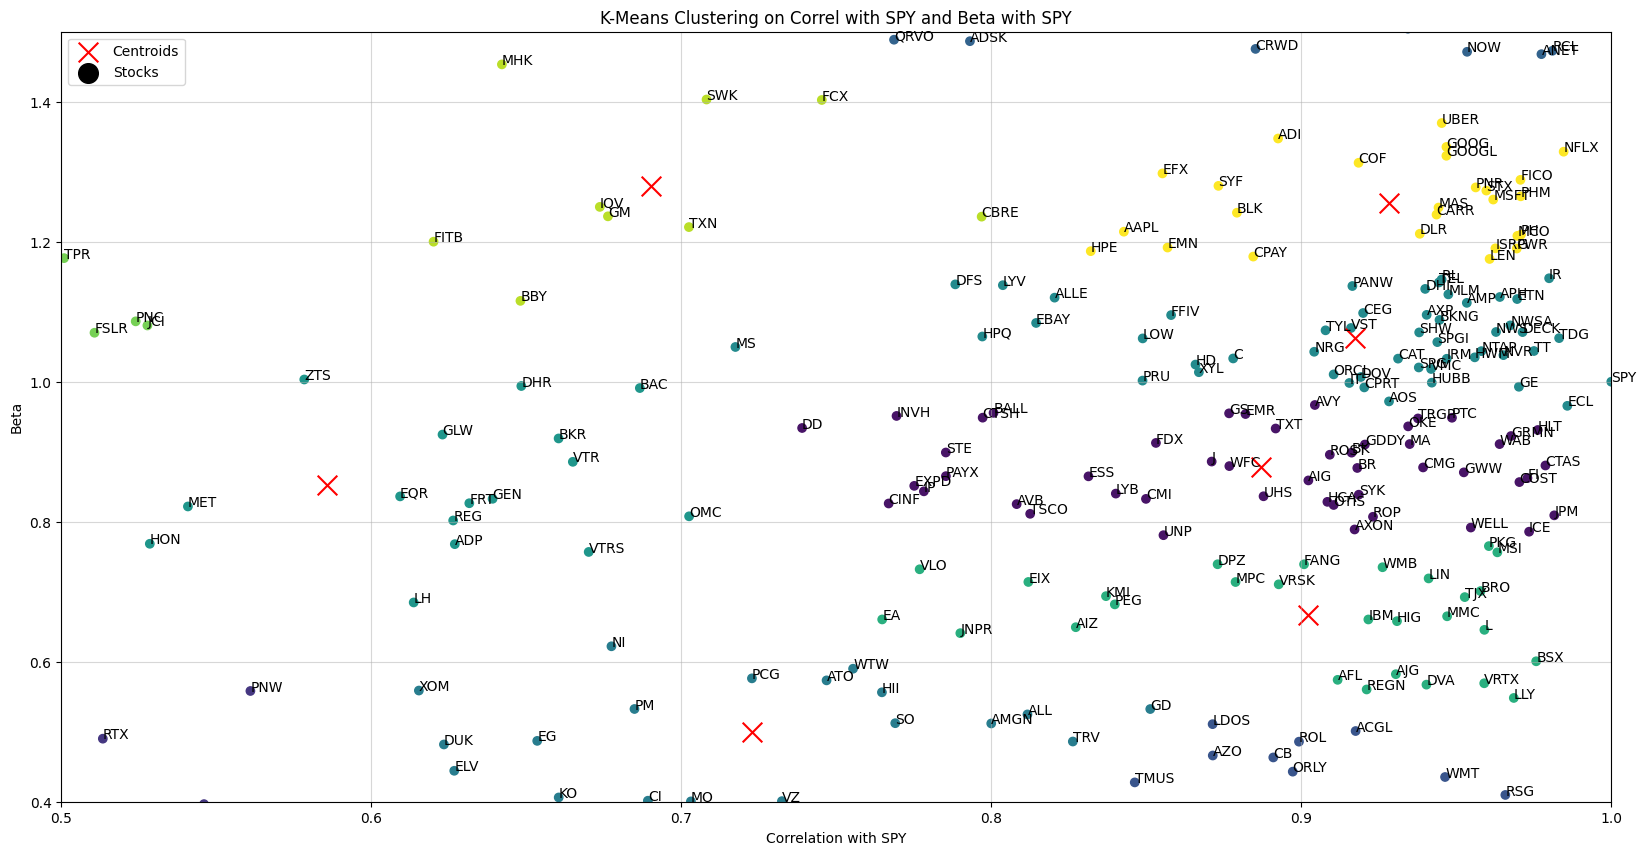

In [12]:

N_CLUSTERS = 20

# Features
X = pd.DataFrame(list(zip(correl_with_SPY_map.values(), beta_map.values())), columns=["Correl", "Beta"])

kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(X)
clusters = kmeans.predict(X)

X["Cluster"] = clusters # Add the clusters to the dataframe

# Plot the clusters
plt.figure(figsize=(20, 10))
plt.scatter(X["Correl"], X["Beta"], c=X["Cluster"], cmap="viridis")
plt.xlabel("Correlation with SPY"), plt.ylabel("Beta")
plt.title("K-Means Clustering on Correl with SPY and Beta with SPY")
plt.grid(alpha=0.5)

# Add labels to each point
for label, correl in correl_with_SPY_map.items():
    beta = beta_map[label]
    plt.annotate(label, (correl, beta))

# Add the centroids to the plot
centroids = kmeans.cluster_centers_ 
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=200, c="red")

# Legend
plt.scatter([], [], marker="x", s=200, color="red", label="Centroids")
plt.scatter([], [], marker="o", s=200, color="black", label="Stocks")
plt.legend()


# Zoom in to not show outliers
plt.ylim(0.4, 1.5)
plt.xlim(0.5, 1)

plt.show()

In [13]:
# Dataframe with rows: stock name, cluster number
cluster_map = pd.DataFrame()
cluster_map['data_index'] = X.index.values
cluster_map['cluster'] = kmeans.labels_
cluster_map['Ticker'] = list(correl_with_SPY_map.keys())

def clean_data(cluster_map):
    # Sort by column: 'cluster' (ascending)
    cluster_map = cluster_map.sort_values(['cluster'])
    return cluster_map

cluster_map_clean = clean_data(cluster_map.copy())

# Append the drifts to the dataframe
cluster_map_clean["E(r)"] = cluster_map_clean["Ticker"].map(er_stocks)

# Sorting by drift, then by cluster
cluster_map_clean = cluster_map_clean.sort_values(["E(r)"], ascending=False)


cluster_map_clean.head()

,data_index,cluster,Ticker,E(r)
328,328,9,VST,1.833602
236,236,13,NVDA,1.694202
175,175,9,IRM,1.273651
188,188,6,KKR,1.202357
146,146,1,GDDY,1.189581


In [14]:
# # Save the dataframe to a CSV file
# cluster_map_clean.to_csv(os.path.join(os.getcwd(), "tmp_cluster_map.csv"))
# os.system("open tmp_cluster_map.csv")

In [15]:
dict_cluster_ticker = {}
for i in range(N_CLUSTERS):
    dict_cluster_ticker[i] = cluster_map_clean[cluster_map_clean['cluster'] == i]['Ticker'].to_list()

# Print the stocks in each cluster
for i in range(N_CLUSTERS):
    print("cluster_{}".format(i), "=", dict_cluster_ticker[i])

cluster_0 = ['ZBRA', 'KEY', 'GNRC', 'IVZ', 'KMX', 'SWKS', 'TROW', 'F']
cluster_1 = ['GDDY', 'UHS', 'TRGP', 'HCA', 'AXON', 'GS', 'GRMN', 'COST', 'JPM', 'BK', 'IP', 'CTAS', 'ICE', 'WAB', 'ESS', 'OKE', 'CMI', 'WFC', 'WELL', 'FI', 'CINF', 'AVB', 'TSCO', 'HLT', 'BALL', 'SYK', 'CMG', 'AVY', 'UNP', 'GWW', 'MA', 'DD', 'ROST', 'EMR', 'AIG', 'BR', 'FDX', 'CTSH', 'STE', 'INVH', 'TXT', 'OTIS', 'PTC', 'PAYX', 'J', 'LYB', 'EXPD', 'ROP']
cluster_2 = ['K', 'TSN', 'O', 'EVRG', 'MKC', 'KDP', 'JNJ', 'NOC', 'GILD', 'CVX', 'PEP']
cluster_3 = ['RTX', 'FOXA', 'FOX', 'T', 'PPL', 'DTE', 'PNW', 'ETR', 'LMT', 'LHX', 'FE', 'CMS', 'KMB', 'DGX', 'ED', 'UNH', 'EOG']
cluster_4 = ['CTLT', 'HAS', 'RF', 'TFC', 'EXR', 'IFF', 'MTD', 'NTRS', 'TECH']
cluster_5 = ['PGR', 'LDOS', 'ABBV', 'CL', 'WMT', 'TMUS', 'RSG', 'ROL', 'ACGL', 'CB', 'WM', 'KR', 'COR', 'MCK', 'MRK', 'AZO', 'PG', 'CBOE', 'CHD', 'ORLY']
cluster_6 = ['KKR', 'RCL', 'AVGO', 'ANET', 'URI', 'META', 'TER', 'KLAC', 'BX', 'WDC', 'QCOM', 'NXPI', 'NOW', 'CRWD', 'AMAT',

# Results
Output the results in .csv file (TradingView watchlist format)

In [16]:
# to_dispose = tickers in crnt_portfolio but not in universe_stocks 
to_dispose = [e for e in crnt_portfolio if e not in universe_stocks]
print("Stocks to dispose:", to_dispose)

Stocks to dispose: ['QQQ']


In [17]:
# Clusters that are not in current portfolio
clusters_to_add = [cluster_map_clean[cluster_map_clean['Ticker'] == e]['cluster'].values[0] for e in crnt_portfolio if e in universe_stocks]
clusters_not_in_portfolio = [e for e in range(N_CLUSTERS) if e not in clusters_to_add]
print("Clusters not in portfolio:", clusters_not_in_portfolio)

Clusters not in portfolio: [0, 2, 3, 4, 7, 11, 13, 16, 18]


In [18]:
# Export the watchlist to a text file (TradingView format; for import to watchlist)
yyyymmdd = pd.Timestamp.now().strftime("%Y%m%d")
with open("new_stocks_watchlist{}.txt".format(yyyymmdd), "w") as f:
    for i in clusters_not_in_portfolio:
        f.write("###CLUSTER {}\n".format(i))
        for stock in dict_cluster_ticker[i]:
            f.write(stock + "\n")
        f.write("\n")

